# Thesis Data Anlysis

C++ files and go files have a different format.

You can interchange base-go and opti-go-length, the rest shall not be modified. 


In [21]:
#pip install nbformat


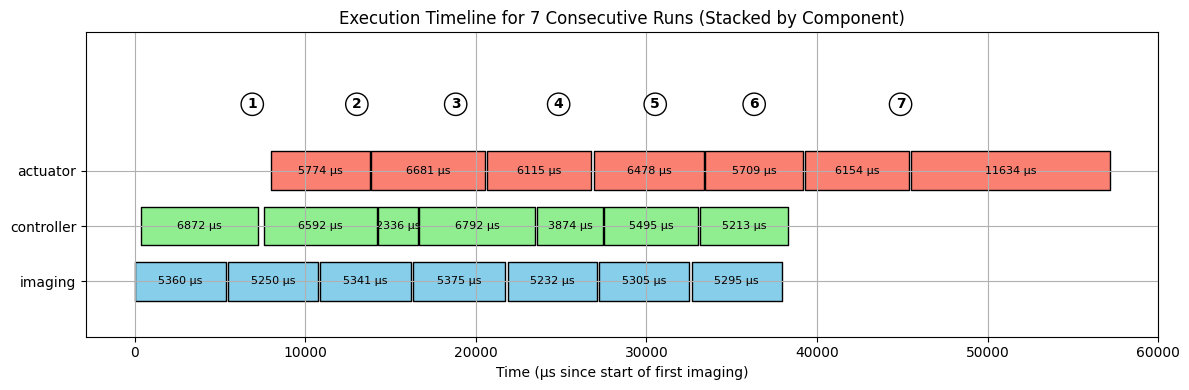

In [22]:
import re
import matplotlib.pyplot as plt

def parse_file_line(line):
    """Extract all key-value pairs and normalize keys to lowercase"""
    # Capture keys like 'Start', 'start', 'id ts', 'idts', etc.
    pairs = re.findall(r'([\w ]+):\s?(\d+)', line.replace('"', '').replace(',', ''))
    return {k.strip().lower(): int(v) for k, v in pairs}

def extract_runs(imaging_lines, controller_lines, actuator_lines):
    """Extract matched runs from all three logs using common id ts"""
    runs = {}

    # Parse imaging.txt
    for line in imaging_lines:
        parsed = parse_file_line(line)
        id_ts = parsed.get('idts') or parsed.get('id ts')
        if id_ts:
            runs[id_ts] = {
                'imaging_start': parsed.get('start'),
                'imaging_end': parsed.get('end'),
            }

    # Parse controller.txt
    for line in controller_lines:
        parsed = parse_file_line(line)
        id_ts = parsed.get('idts') or parsed.get('id ts')
        if id_ts in runs:
            runs[id_ts].update({
                'controller_start': parsed.get('start'),
                'controller_end': parsed.get('end'),
            })

    # Parse actuator.txt
    for line in actuator_lines:
        parsed = parse_file_line(line)
        id_ts = parsed.get('idts') or parsed.get('id ts')
        if id_ts in runs:
            runs[id_ts].update({
                'actuator_start': parsed.get('start'),
                'actuator_end': parsed.get('end'),
            })

    # Keep only complete records (with all 3 components)
    complete_runs = [v for v in runs.values() if len(v) == 6]
    return complete_runs

def plot_runs(runs, num_runs=4):
    """Plot execution timeline for first N runs"""
    components = ['imaging', 'controller', 'actuator']
    colors = {'imaging': 'skyblue', 'controller': 'lightgreen', 'actuator': 'salmon'}
    base_time = runs[0]['imaging_start']

    fig, ax = plt.subplots(figsize=(12, 4))

    for idx, run in enumerate(runs[:num_runs]):
        group_min_time = float('inf')
        group_max_time = 0

        for comp_idx, comp in enumerate(components):
            start = run[f'{comp}_start'] - base_time
            duration = run[f'{comp}_end'] - run[f'{comp}_start']
            y_pos = comp_idx

            # Draw bar with border
            ax.broken_barh(
                [(start, duration)],
                (y_pos - 0.35, 0.7),
                facecolors=colors[comp],
                edgecolors='black',
                linewidth=1
            )

            ax.text(
                start + duration / 2,
                y_pos,
                f'{duration} µs',
                va='center',
                ha='center',
                fontsize=8
            )

            # Track min/max for run label positioning
            group_min_time = min(group_min_time, start)
            group_max_time = max(group_max_time, start + duration)

        # Add run number above group
        mid_time = (group_min_time + group_max_time) / 2
        ax.text(
            mid_time,
            len(components) + 0.2,
            f'{idx + 1}',
            ha='center',
            va='center',
            fontsize=10,
            fontweight='bold',
            color='black',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='circle,pad=0.3')
        )

    # Y-axis setup
    ax.set_yticks(range(len(components)))
    ax.set_yticklabels(components)
    ax.set_xlabel('Time (µs since start of first imaging)')
    ax.set_title(f'Execution Timeline for {min(num_runs, len(runs))} Consecutive Runs (Stacked by Component)')
    ax.set_ylim(-1, len(components) + 1.5)
    ax.grid(True)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # Load files
    with open("intercom/imaging.txt") as f1, open("intercom/controller.txt") as f2, open("intercom/actuator.txt") as f3:
        imaging_lines = f1.readlines()
        controller_lines = f2.readlines()
        actuator_lines = f3.readlines()

    runs = extract_runs(imaging_lines, controller_lines, actuator_lines)
    if runs:
        plot_runs(runs, num_runs=7)
    else:
        print("No complete runs found with matching id ts in all 3 files.")


Average time differences (µs):
Controller - Imaging: 419.29
Controller - Actuator: -74407.78
Imaging - Actuator: -74827.07


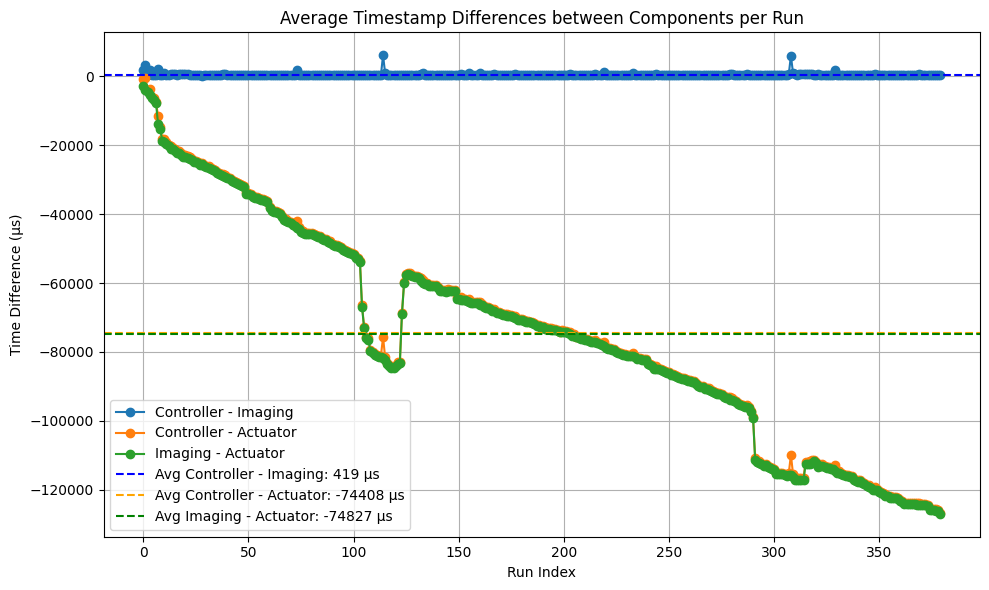

In [23]:
import re
import matplotlib.pyplot as plt
import numpy as np

def parse_file_line(line):
    line = line.replace('"', '').replace(',', '')
    pairs = re.findall(r'([\w ]+):\s?([\d]+)', line)
    return {k.strip().lower(): v for k, v in pairs}

def extract_runs_compare(cpp_lines, controller_lines, actuator_lines):
    runs = {}

    for line in cpp_lines:
        parsed = parse_file_line(line)
        id_ts = parsed.get('idts') or parsed.get('id ts')
        if id_ts:
            runs[id_ts] = {
                'imaging_end': int(parsed.get('end', 0)),
            }

    for line in controller_lines:
        parsed = parse_file_line(line)
        id_ts = parsed.get('idts') or parsed.get('id ts')
        if id_ts in runs:
            recv = parsed.get('recv') or parsed.get('recv data')
            if recv:
                runs[id_ts]['controller_recv'] = int(recv)

    for line in actuator_lines:
        parsed = parse_file_line(line)
        id_ts = parsed.get('idts') or parsed.get('id ts')
        if id_ts in runs:
            rcv_data = parsed.get('rcv data')
            if rcv_data:
                runs[id_ts]['actuator_rcv_data'] = int(rcv_data)

    complete_runs = {
        k: v for k, v in runs.items()
        if all(key in v for key in ['imaging_end', 'controller_recv', 'actuator_rcv_data'])
    }
    return complete_runs

def plot_and_print_averages(runs):
    ids = list(runs.keys())
    c_minus_i = []
    c_minus_a = []
    i_minus_a = []

    for idts in ids:
        run = runs[idts]
        c = run['controller_recv']
        i = run['imaging_end']
        a = run['actuator_rcv_data']

        c_minus_i.append(c - i)
        c_minus_a.append(c - a)
        i_minus_a.append(i - a)

    # Calculate averages
    avg_c_minus_i = np.mean(c_minus_i)
    avg_c_minus_a = np.mean(c_minus_a)
    avg_i_minus_a = np.mean(i_minus_a)

    print("Average time differences (µs):")
    print(f"Controller - Imaging: {avg_c_minus_i:.2f}")
    print(f"Controller - Actuator: {avg_c_minus_a:.2f}")
    print(f"Imaging - Actuator: {avg_i_minus_a:.2f}")

    plt.figure(figsize=(10,6))
    x = range(len(ids))

    plt.plot(x, c_minus_i, marker='o', label='Controller - Imaging')
    plt.plot(x, c_minus_a, marker='o', label='Controller - Actuator')
    plt.plot(x, i_minus_a, marker='o', label='Imaging - Actuator')

    plt.axhline(avg_c_minus_i, color='blue', linestyle='--', label=f'Avg Controller - Imaging: {avg_c_minus_i:.0f} µs')
    plt.axhline(avg_c_minus_a, color='orange', linestyle='--', label=f'Avg Controller - Actuator: {avg_c_minus_a:.0f} µs')
    plt.axhline(avg_i_minus_a, color='green', linestyle='--', label=f'Avg Imaging - Actuator: {avg_i_minus_a:.0f} µs')

    plt.xlabel('Run Index')
    plt.ylabel('Time Difference (µs)')
    plt.title('Average Timestamp Differences between Components per Run')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    with open("intercom/imaging.txt") as f1, open("intercom/controller.txt") as f2, open("intercom/actuator.txt") as f3:
        cpp_lines = f1.readlines()
        controller_lines = f2.readlines()
        actuator_lines = f3.readlines()

    matched_runs = extract_runs_compare(cpp_lines, controller_lines, actuator_lines)

    if matched_runs:
        plot_and_print_averages(matched_runs)
    else:
        print("No complete runs found with matching id ts in all 3 files.")


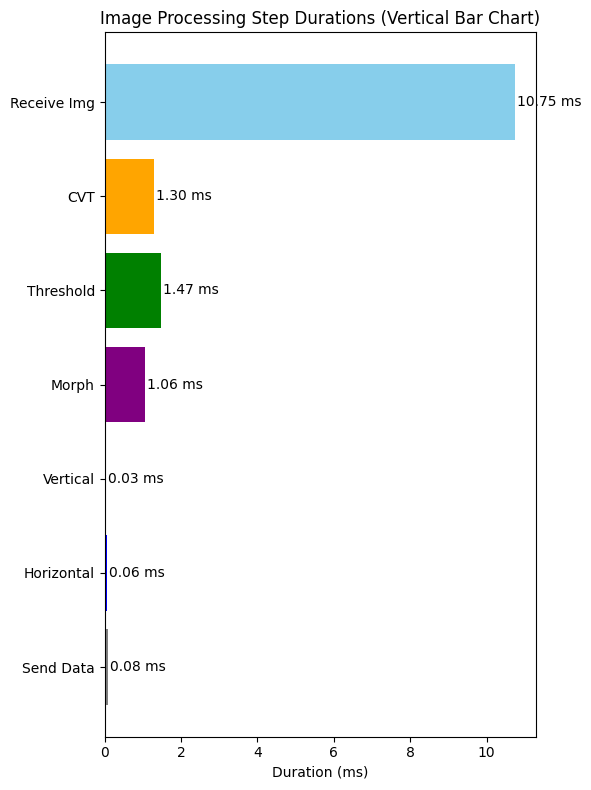

In [24]:
import matplotlib.pyplot as plt

# Extracted timestamps from imaging.txt
timestamps = {
    "start": 1750346841696896,
    "recvImg": 1750346841707643,
    "cvt": 1750346841708942,
    "thresh": 1750346841710407,
    "morph": 1750346841711464,
    "vertical": 1750346841711497,
    "horizontal": 1750346841711553,
    "end": 1750346841711636
}

# Compute durations (in milliseconds)
durations = {
    "Receive Img": (timestamps["recvImg"] - timestamps["start"]) / 1000,
    "CVT": (timestamps["cvt"] - timestamps["recvImg"]) / 1000,
    "Threshold": (timestamps["thresh"] - timestamps["cvt"]) / 1000,
    "Morph": (timestamps["morph"] - timestamps["thresh"]) / 1000,
    "Vertical": (timestamps["vertical"] - timestamps["morph"]) / 1000,
    "Horizontal": (timestamps["horizontal"] - timestamps["vertical"]) / 1000,
    "Send Data": (timestamps["end"] - timestamps["horizontal"]) / 1000
}

# Plot
labels = list(durations.keys())
values = list(durations.values())
colors = ['skyblue', 'orange', 'green', 'purple', 'red', 'blue', 'gray']

plt.figure(figsize=(6, 8))
bars = plt.barh(labels, values, color=colors)
plt.xlabel("Duration (ms)")
plt.title("Image Processing Step Durations (Vertical Bar Chart)")

# Add labels to bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.05, bar.get_y() + bar.get_height() / 2,
             f'{width:.2f} ms', va='center')

plt.gca().invert_yaxis()  # So that "Receive Img" is at the top
plt.tight_layout()
plt.show()


Skipping line due to error: invalid literal for int() with base 10: 'info'


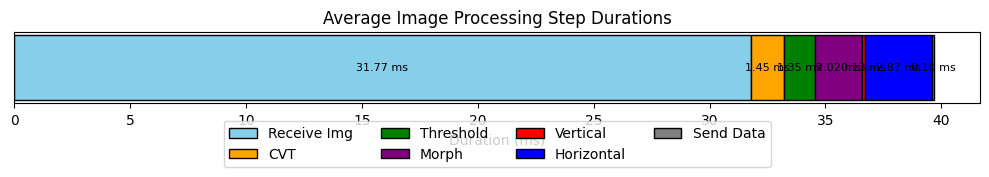

In [25]:
import matplotlib.pyplot as plt

# Define the file path
filename = 'base-go-live/imaging.txt'

# Store results for each frame
all_durations = []

with open(filename, 'r') as f:
    for line in f:
        if "start" not in line:
            continue  # skip malformed lines

        try:
            # Extract timestamps
            parts = {k.strip(): int(v.strip()) for part in line.strip().split(",") if ":" in part
                     for k, v in [part.replace('"', '').split(":", 1)]}

            # Compute durations in milliseconds
            durations = {
                "Receive Img": (parts["recvImg"] - parts["start"]) / 1000,
                "CVT": (parts["cvt"] - parts["recvImg"]) / 1000,
                "Threshold": (parts["thresh"] - parts["cvt"]) / 1000,
                "Morph": (parts["morph"] - parts["thresh"]) / 1000,
                "Vertical": (parts["vertical"] - parts["morph"]) / 1000,
                "Horizontal": (parts["horizontal"] - parts["vertical"]) / 1000,
                "Send Data": (parts["end"] - parts["horizontal"]) / 1000
            }
            all_durations.append(durations)
        except Exception as e:
            print(f"Skipping line due to error: {e}")

# Compute average durations
labels = list(all_durations[0].keys())
average_durations = {key: 0 for key in labels}
num_frames = len(all_durations)

for frame in all_durations:
    for key in labels:
        average_durations[key] += frame[key]
for key in average_durations:
    average_durations[key] /= num_frames

# --- Plot: Single stacked horizontal bar chart for average durations ---
colors = ['skyblue', 'orange', 'green', 'purple', 'red', 'blue', 'gray']
values = [average_durations[key] for key in labels]

plt.figure(figsize=(10, 2))
left = 0
for i, (label, value) in enumerate(zip(labels, values)):
    plt.barh(0, value, left=left, color=colors[i], edgecolor='black', label=label)
    plt.text(left + value / 2, 0, f'{value:.2f} ms', va='center', ha='center', fontsize=8)
    left += value

plt.yticks([])
plt.xlabel("Duration (ms)")
plt.title("Average Image Processing Step Durations")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.tight_layout()
plt.show()


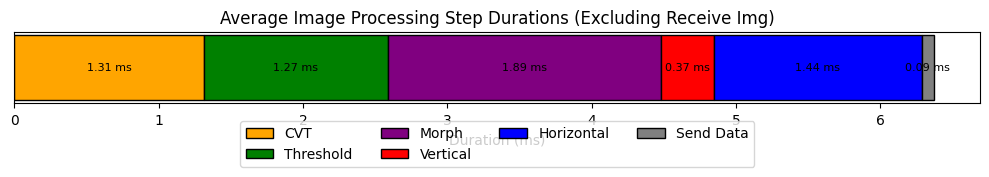

Total average time (sum of all stages) : 6.37 ms


In [26]:
import matplotlib.pyplot as plt

# Define the file path
filename = 'base-go/imaging.txt'

# Store results for each frame
all_durations = []

with open(filename, 'r') as f:
    for line in f:
        if "start" not in line:
            continue  # skip malformed lines

        try:
            # Extract timestamps
            parts = {k.strip(): int(v.strip()) for part in line.strip().split(",") if ":" in part
                     for k, v in [part.replace('"', '').split(":", 1)]}

            # Compute durations in milliseconds (excluding "Receive Img")
            durations = {
                "CVT": (parts["cvt"] - parts["recvImg"]) / 1000,
                "Threshold": (parts["thresh"] - parts["cvt"]) / 1000,
                "Morph": (parts["morph"] - parts["thresh"]) / 1000,
                "Vertical": (parts["vertical"] - parts["morph"]) / 1000,
                "Horizontal": (parts["horizontal"] - parts["vertical"]) / 1000,
                "Send Data": (parts["end"] - parts["horizontal"]) / 1000
            }
            all_durations.append(durations)
        except Exception as e:
            print(f"Skipping line due to error: {e}")

# Compute average durations
labels = list(all_durations[0].keys())
average_durations = {key: 0 for key in labels}
num_frames = len(all_durations)

for frame in all_durations:
    for key in labels:
        average_durations[key] += frame[key]
for key in average_durations:
    average_durations[key] /= num_frames

# --- Plot: Single stacked horizontal bar chart for average durations (excluding Receive Img) ---
colors = ['orange', 'green', 'purple', 'red', 'blue', 'gray']
values = [average_durations[key] for key in labels]

plt.figure(figsize=(10, 2))
left = 0
for i, (label, value) in enumerate(zip(labels, values)):
    plt.barh(0, value, left=left, color=colors[i], edgecolor='black', label=label)
    plt.text(left + value / 2, 0, f'{value:.2f} ms', va='center', ha='center', fontsize=8)
    left += value

plt.yticks([])
plt.xlabel("Duration (ms)")
plt.title("Average Image Processing Step Durations (Excluding Receive Img)")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.tight_layout()
plt.show()

# --- compute & print total ---
total_ms = sum(values)
print(f"Total average time (sum of all stages) : {total_ms:.2f} ms")


Error parsing line: invalid literal for int() with base 10: 'info'


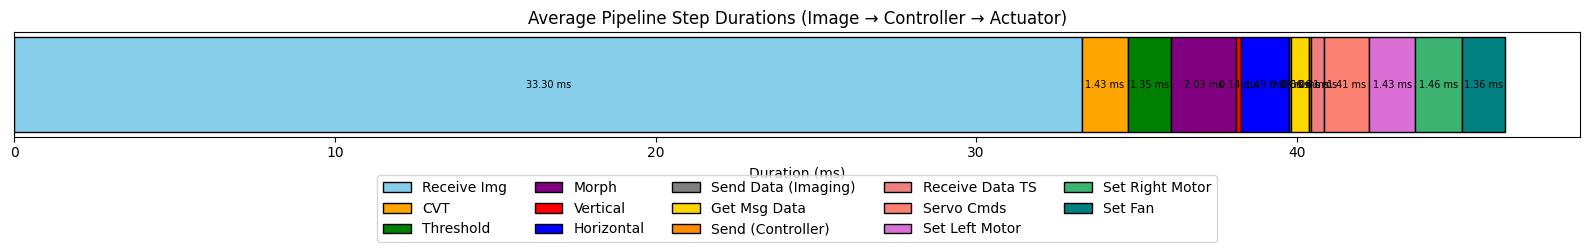

Receive Img: Average = 33.3034 ms, Variance = 1.532778 ms²
CVT: Average = 1.4282 ms, Variance = 0.731383 ms²
Threshold: Average = 1.3502 ms, Variance = 0.040061 ms²
Morph: Average = 2.0309 ms, Variance = 0.036067 ms²
Vertical: Average = 0.1423 ms, Variance = 0.023078 ms²
Horizontal: Average = 1.4897 ms, Variance = 0.022265 ms²
Send Data (Imaging): Average = 0.0846 ms, Variance = 0.000096 ms²
Get Msg Data: Average = 0.5566 ms, Variance = 0.009968 ms²
Send (Controller): Average = 0.0593 ms, Variance = 0.000712 ms²
Receive Data TS: Average = 0.4086 ms, Variance = 0.041087 ms²
Servo Cmds: Average = 1.4085 ms, Variance = 0.002892 ms²
Set Left Motor: Average = 1.4296 ms, Variance = 0.203059 ms²
Set Right Motor: Average = 1.4552 ms, Variance = 1.089727 ms²
Set Fan: Average = 1.3646 ms, Variance = 0.000527 ms²


In [27]:
import matplotlib.pyplot as plt

# Define the file paths base-go-live
imaging_file = 'base-go-live/imaging.txt'
controller_file = 'base-go-live/controller.txt'
actuator_file = 'base-go-live/actuator.txt'

# Function to parse a line into a dict of key-value pairs
def parse_line(line):
    return {k.strip(): int(v.strip()) for part in line.strip().split(",") if ":" in part
            for k, v in [part.replace('"', '').split(":", 1)]}

# Load all lines
with open(imaging_file, 'r') as f:
    imaging_lines = [line for line in f if 'start' in line]
with open(controller_file, 'r') as f:
    controller_lines = [line for line in f if 'start' in line]
with open(actuator_file, 'r') as f:
    actuator_lines = [line for line in f if 'Start' in line]

# Match by "id ts"
matched_durations = []

for img_line in imaging_lines:
    try:
        img_data = parse_line(img_line)
        img_id = img_data.get("id ts")
        if not img_id:
            continue

        # Find matching controller line
        ctrl_line = next((l for l in controller_lines if f'id ts:{img_id}' in l), None)
        if not ctrl_line:
            continue
        ctrl_data = parse_line(ctrl_line)

        # Find matching actuator line
        act_line = next((l for l in actuator_lines if f'id ts:{img_id}' in l), None)
        if not act_line:
            continue
        act_data = parse_line(act_line)

        # Compute durations in milliseconds
        durations = {
            # Imaging
            "Receive Img": (img_data["recvImg"] - img_data["start"]) / 1000,
            "CVT": (img_data["cvt"] - img_data["recvImg"]) / 1000,
            "Threshold": (img_data["thresh"] - img_data["cvt"]) / 1000,
            "Morph": (img_data["morph"] - img_data["thresh"]) / 1000,
            "Vertical": (img_data["vertical"] - img_data["morph"]) / 1000,
            "Horizontal": (img_data["horizontal"] - img_data["vertical"]) / 1000,
            "Send Data (Imaging)": (img_data["end"] - img_data["horizontal"]) / 1000,
            # Controller
            "Get Msg Data": (ctrl_data["send"] - img_data["horizontal"]) / 1000,
            "Send (Controller)": (ctrl_data["End(controller)"] - ctrl_data["send"]) / 1000,
            # Actuator
            "Receive Data TS": (act_data["rcv data TS"] - ctrl_data["End(controller)"]) / 1000,
            "Servo Cmds": (act_data["servo cmds"] - act_data["rcv data TS"]) / 1000,
            "Set Left Motor": (act_data["setLeft motor"] - act_data["servo cmds"]) / 1000,
            "Set Right Motor": (act_data["set Right motor"] - act_data["setLeft motor"]) / 1000,
            "Set Fan": (act_data["set fan"] - act_data["set Right motor"]) / 1000
        }

        matched_durations.append(durations)
    except Exception as e:
        print(f"Error parsing line: {e}")

# Compute average durations
if not matched_durations:
    raise ValueError("No matching data found.")

labels = list(matched_durations[0].keys())
average_durations = {key: 0 for key in labels}
num_frames = len(matched_durations)

for frame in matched_durations:
    for key in labels:
        average_durations[key] += frame[key]
for key in average_durations:
    average_durations[key] /= num_frames

# --- Plot: Single stacked horizontal bar chart for average durations ---
colors = [
    'skyblue', 'orange', 'green', 'purple', 'red', 'blue', 'gray',  # imaging
    'gold', 'darkorange',                                           # controller
    'lightcoral', 'salmon', 'orchid', 'mediumseagreen', 'teal'     # actuator
]
values = [average_durations[key] for key in labels]

plt.figure(figsize=(16, 3))
left = 0
for i, (label, value) in enumerate(zip(labels, values)):
    plt.barh(0, value, left=left, color=colors[i % len(colors)], edgecolor='black', label=label)
    plt.text(left + value / 2, 0, f'{value:.2f} ms', va='center', ha='center', fontsize=7)
    left += value

plt.yticks([])
plt.xlabel("Duration (ms)")
plt.title("Average Pipeline Step Durations (Image → Controller → Actuator)")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=5)
plt.tight_layout()
plt.show()
import numpy as np

# Compute variance for each step
step_variances = {}
for key in labels:
    step_values = [frame[key] for frame in matched_durations]
    step_variances[key] = np.var(step_values)

# Compute variance and print both average and variance per step
for key in labels:
    step_values = [frame[key] for frame in matched_durations]
    variance = np.var(step_values)
    avg = average_durations[key]
    print(f"{key}: Average = {avg:.4f} ms, Variance = {variance:.6f} ms²")




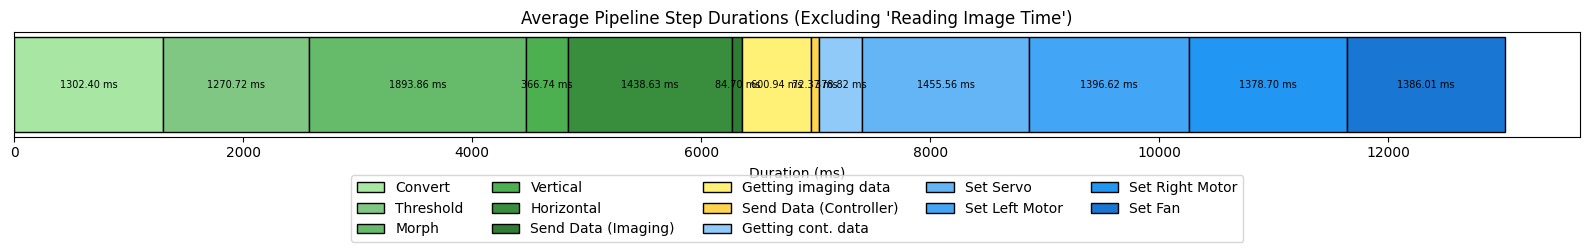


Pipeline Step Averages and Standard Deviations (in µs):
Convert: 1302.40 µs ± 387.09 µs
Threshold: 1270.72 µs ± 289.74 µs
Morph: 1893.86 µs ± 237.69 µs
Vertical: 366.74 µs ± 143.22 µs
Horizontal: 1438.63 µs ± 264.72 µs
Send Data (Imaging): 84.70 µs ± 16.18 µs
Getting imaging data: 600.94 µs ± 440.37 µs
Send Data (Controller): 72.37 µs ± 33.47 µs
Getting cont. data: 378.82 µs ± 347.28 µs
Set Servo: 1455.56 µs ± 704.50 µs
Set Left Motor: 1396.62 µs ± 359.08 µs
Set Right Motor: 1378.70 µs ± 155.63 µs
Set Fan: 1386.01 µs ± 304.68 µs

Average standard deviation across all steps: 283.36 µs


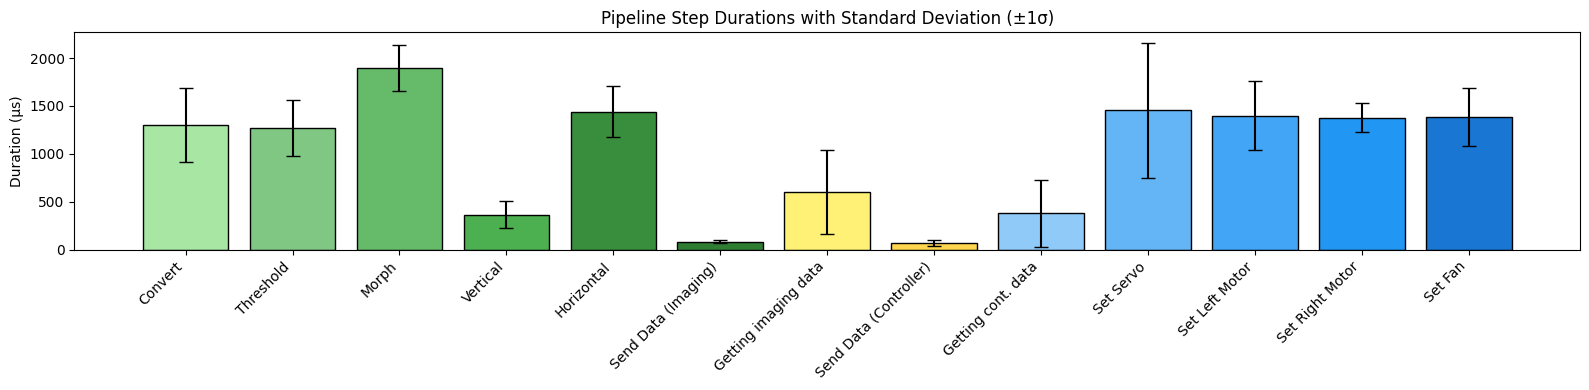


Total average end-to-end pipeline duration: 13026.071 ms (13026 µs)


In [28]:
import matplotlib.pyplot as plt

# Define the file paths opti-go-length/imaging.txt'
imaging_file = 'base-go/imaging.txt'
controller_file = 'base-go/controller.txt'
actuator_file = 'base-go/actuator.txt'

# Function to parse a line into a dict of key-value pairs
def parse_line(line):
    return {k.strip(): int(v.strip()) for part in line.strip().split(",") if ":" in part
            for k, v in [part.replace('"', '').split(":", 1)]}

# Load all lines
with open(imaging_file, 'r') as f:
    imaging_lines = [line for line in f if 'start' in line]
with open(controller_file, 'r') as f:
    controller_lines = [line for line in f if 'start' in line]
with open(actuator_file, 'r') as f:
    actuator_lines = [line for line in f if 'Start' in line]

# Match by "id ts"
matched_durations = []

for img_line in imaging_lines:
    try:
        img_data = parse_line(img_line)
        img_id = img_data.get("id ts")
        if not img_id:
            continue

        # Find matching controller line
        ctrl_line = next((l for l in controller_lines if f'id ts:{img_id}' in l), None)
        if not ctrl_line:
            continue
        ctrl_data = parse_line(ctrl_line)

        # Find matching actuator line
        act_line = next((l for l in actuator_lines if f'id ts:{img_id}' in l), None)
        if not act_line:
            continue
        act_data = parse_line(act_line)

        # Compute durations in milliseconds (EXCLUDING "Receive Img")
        # Compute durations in microseconds (µs)
        durations = {
            "Convert": (img_data["cvt"] - img_data["recvImg"]),
            "Threshold": (img_data["thresh"] - img_data["cvt"]),
            "Morph": (img_data["morph"] - img_data["thresh"]),
            "Vertical": (img_data["vertical"] - img_data["morph"]),
            "Horizontal": (img_data["horizontal"] - img_data["vertical"]),
            "Send Data (Imaging)": (img_data["end"] - img_data["horizontal"]),
            "Getting imaging data": (ctrl_data["send"] - img_data["horizontal"]),
            "Send Data (Controller)": (ctrl_data["End(controller)"] - ctrl_data["send"]),
            "Getting cont. data": (act_data["rcv data TS"] - ctrl_data["End(controller)"]),
            "Set Servo": (act_data["servo cmds"] - act_data["rcv data TS"]),
            "Set Left Motor": (act_data["setLeft motor"] - act_data["servo cmds"]),
            "Set Right Motor": (act_data["set Right motor"] - act_data["setLeft motor"]),
            "Set Fan": (act_data["set fan"] - act_data["set Right motor"])
        }


        matched_durations.append(durations)
    except Exception as e:
        print(f"Error parsing line: {e}")

# Compute average durations
if not matched_durations:
    raise ValueError("No matching data found.")

labels = list(matched_durations[0].keys())
average_durations = {key: 0 for key in labels}
num_frames = len(matched_durations)

for frame in matched_durations:
    for key in labels:
        average_durations[key] += frame[key]
for key in average_durations:
    average_durations[key] /= num_frames

# --- Plot: Single stacked horizontal bar chart for average durations ---
imaging_colors = [
    '#A8E6A3',  # CVT
    '#81C784',  # Threshold
    '#66BB6A',  # Morph
    '#4CAF50',  # Vertical
    '#388E3C',  # Horizontal
    '#2E7D32'   # Send Data (Imaging)
]
controller_colors = [
    '#FFF176',  # Getting imaging data
    '#FFD54F'   # Send (Controller)
]
actuator_colors = [
    '#90CAF9',  # Getting cont. data
    '#64B5F6',  # Servo Cmds
    '#42A5F5',  # Set Left Motor
    '#2196F3',  # Set Right Motor
    '#1976D2'   # Set Fan
]
colors = imaging_colors + controller_colors + actuator_colors


# colors = [
#     'orange', 'green', 'purple', 'red', 'blue', 'gray',             # imaging (excluding recv img)
#     'gold', 'darkorange',                                           # controller
#     'lightcoral', 'salmon', 'orchid', 'mediumseagreen', 'teal'     # actuator
# ]
values = [average_durations[key] for key in labels]

plt.figure(figsize=(16, 3))
left = 0
for i, (label, value) in enumerate(zip(labels, values)):
    plt.barh(0, value, left=left, color=colors[i % len(colors)], edgecolor='black', label=label)
    plt.text(left + value / 2, 0, f'{value:.2f} ms', va='center', ha='center', fontsize=7)
    left += value

plt.yticks([])
plt.xlabel("Duration (ms)")
plt.title("Average Pipeline Step Durations (Excluding 'Reading Image Time')")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=5)
plt.tight_layout()
plt.show()
# --- Compute standard deviation in µs ---
step_stddev_us = {
    key: np.std([frame[key] for frame in matched_durations])  # µs
    for key in labels
}

# --- Print average and std dev per step ---
print("\nPipeline Step Averages and Standard Deviations (in µs):")
for step in labels:
    avg_us = average_durations[step] 
    std_us = step_stddev_us[step]
    print(f"{step}: {avg_us:.2f} µs ± {std_us:.2f} µs")

# --- Compute overall average standard deviation ---
avg_stddev_us = np.mean(list(step_stddev_us.values()))
print(f"\nAverage standard deviation across all steps: {avg_stddev_us:.2f} µs")
# --- Plot: Avg duration with error bars (±1σ) ---
avg_us_values = [average_durations[k]  for k in labels]
std_us_values = [step_stddev_us[k] for k in labels]

plt.figure(figsize=(16, 4))
plt.bar(labels, avg_us_values, yerr=std_us_values, capsize=5, color=colors, edgecolor='black')
plt.ylabel("Duration (µs)")
plt.title("Pipeline Step Durations with Standard Deviation (±1σ)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Compute and show total pipeline duration ---
total_duration_ms = sum(average_durations.values())
total_duration_us = total_duration_ms 

print(f"\nTotal average end-to-end pipeline duration: {total_duration_ms:.3f} ms ({total_duration_us:.0f} µs)")


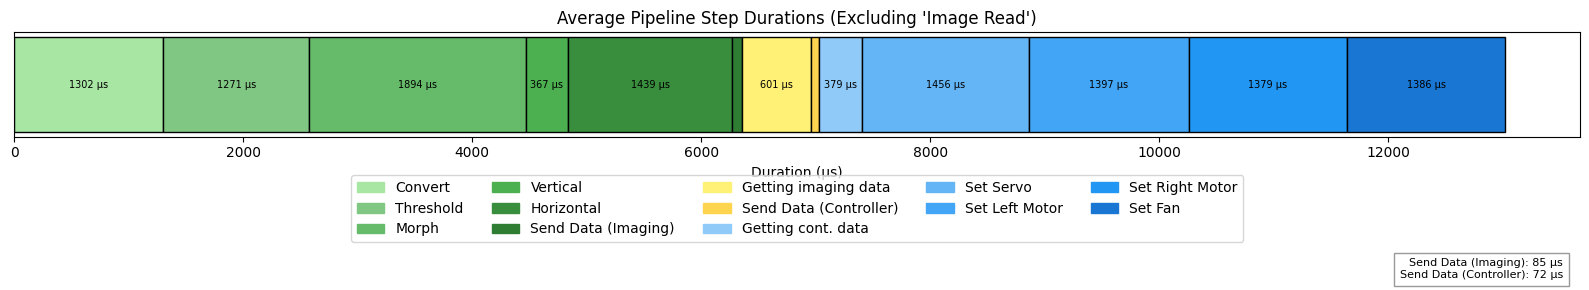

In [29]:
import matplotlib.patches as mpatches

plt.figure(figsize=(16, 3))
left = 0
summary_lines = []

for i, (label, value) in enumerate(zip(labels, values)):
    plt.barh(0, value, left=left, color=colors[i], edgecolor='black')

    # Threshold to decide if we can fit the label inside (adjust as needed)
    if value > 200:  # value in µs (e.g., 200 µs threshold)
        plt.text(left + value / 2, 0, f'{value:.0f} µs', va='center', ha='center', fontsize=7, color='black')
    else:
        # Add to external summary box instead
        summary_lines.append(f"{label}: {value:.0f} µs")

    left += value

plt.yticks([])
plt.xlabel("Duration (µs)")
plt.title("Average Pipeline Step Durations (Excluding 'Image Read')")

# Add the summary text box for small segments
if summary_lines:
    summary_text = "\n".join(summary_lines)
    plt.gcf().text(0.98, 0.05, summary_text, fontsize=8, va='bottom', ha='right',
                   bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

# Optional custom legend
custom_patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(labels))]
plt.legend(handles=custom_patches, loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=5)

plt.tight_layout()
plt.show()


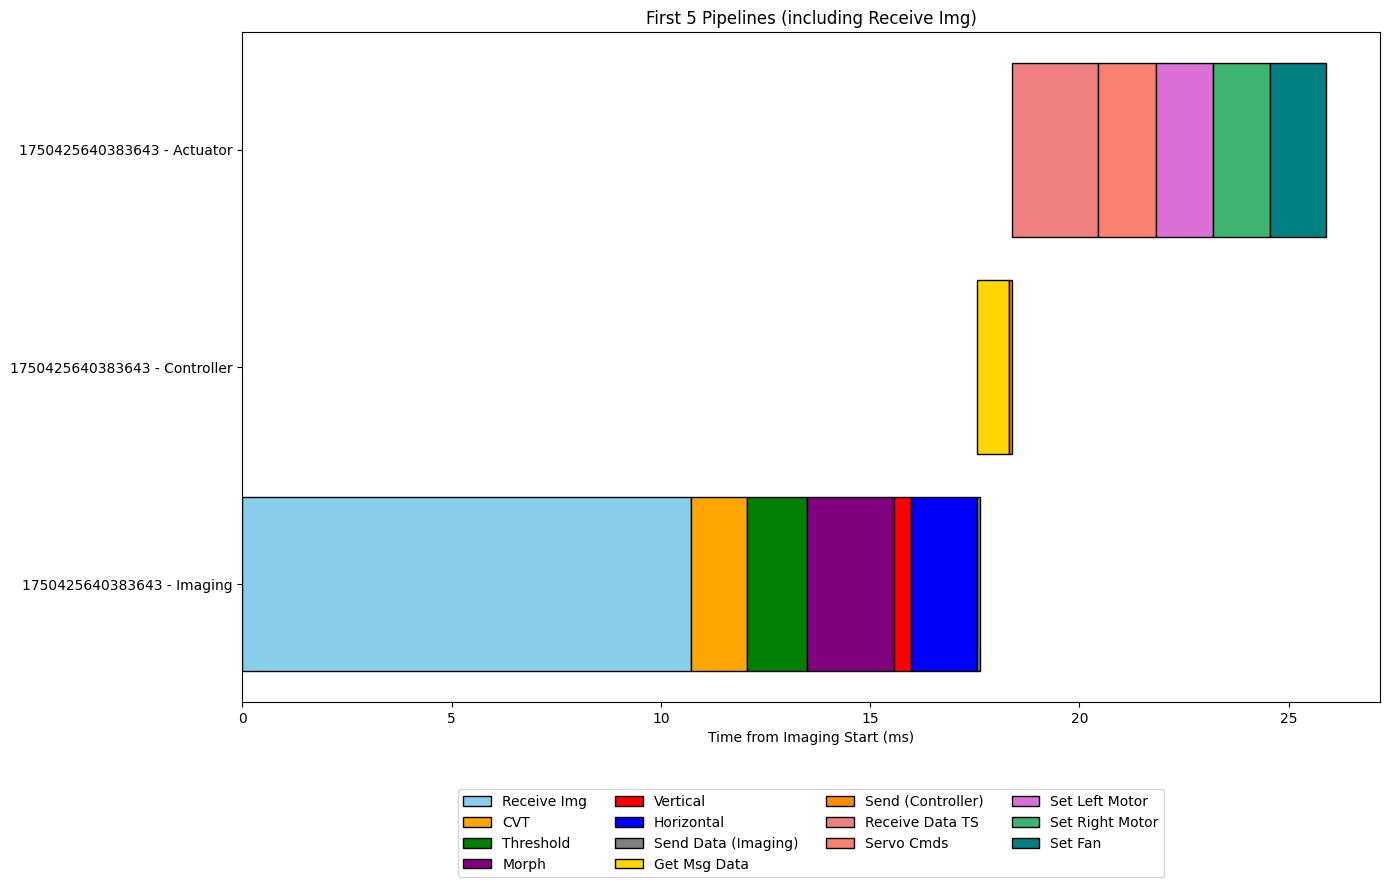

In [30]:
import matplotlib.pyplot as plt

# File paths
imaging_file = 'base-go/imaging.txt'
controller_file = 'base-go/controller.txt'
actuator_file = 'base-go/actuator.txt'

# Parse a line into dict
def parse_line(line):
    return {k.strip(): int(v.strip()) for part in line.strip().split(",") if ":" in part
            for k, v in [part.replace('"', '').split(":", 1)]}

# Load lines
with open(imaging_file, 'r') as f:
    imaging_lines = [line for line in f if 'start' in line]
with open(controller_file, 'r') as f:
    controller_lines = [line for line in f if 'start' in line]
with open(actuator_file, 'r') as f:
    actuator_lines = [line for line in f if 'Start' in line]

# Match data
matches = []
for img_line in imaging_lines:
    try:
        img_data = parse_line(img_line)
        img_id = img_data.get("id ts")
        if not img_id:
            continue

        ctrl_line = next((l for l in controller_lines if f'id ts:{img_id}' in l), None)
        if not ctrl_line:
            continue
        ctrl_data = parse_line(ctrl_line)

        act_line = next((l for l in actuator_lines if f'id ts:{img_id}' in l), None)
        if not act_line:
            continue
        act_data = parse_line(act_line)

        matches.append((img_id, img_data, ctrl_data, act_data))
        if len(matches) >= 1:
            break
    except Exception as e:
        print(f"Error matching id ts: {e}")

# Plotting
colors = {
    "Receive Img": 'skyblue',
    "CVT": 'orange',
    "Threshold": 'green',
    "Morph": 'purple',
    "Vertical": 'red',
    "Horizontal": 'blue',
    "Send Data (Imaging)": 'gray',
    "Get Msg Data": 'gold',
    "Send (Controller)": 'darkorange',
    "Receive Data TS": 'lightcoral',
    "Servo Cmds": 'salmon',
    "Set Left Motor": 'orchid',
    "Set Right Motor": 'mediumseagreen',
    "Set Fan": 'teal'
}

plt.figure(figsize=(14, 9))
yticks = []
yticklabels = []

for i, (id_ts, img, ctrl, act) in enumerate(matches):
    try:
        y_offset = i * 3
        base_time = img["start"]  # anchor for relative timing

        # Imaging stages (with Receive Img added)
        imaging_stages = [
            ("Receive Img", img["start"], img["recvImg"]),
            ("CVT", img["recvImg"], img["cvt"]),
            ("Threshold", img["cvt"], img["thresh"]),
            ("Morph", img["thresh"], img["morph"]),
            ("Vertical", img["morph"], img["vertical"]),
            ("Horizontal", img["vertical"], img["horizontal"]),
            ("Send Data (Imaging)", img["horizontal"], img["end"])
        ]
        for stage, t_start, t_end in imaging_stages:
            start_rel = (t_start - base_time) / 1000
            dur = (t_end - t_start) / 1000
            plt.barh(y_offset, dur, left=start_rel, color=colors[stage], edgecolor='black')

        # Controller stages
        controller_stages = [
            ("Get Msg Data", img["horizontal"], ctrl["send"]),
            ("Send (Controller)", ctrl["send"], ctrl["End(controller)"])
        ]
        for stage, t_start, t_end in controller_stages:
            start_rel = (t_start - base_time) / 1000
            dur = (t_end - t_start) / 1000
            plt.barh(y_offset + 1, dur, left=start_rel, color=colors[stage], edgecolor='black')

        # Actuator stages
        actuator_stages = [
            ("Receive Data TS", ctrl["End(controller)"], act["rcv data TS"]),
            ("Servo Cmds", act["rcv data TS"], act["servo cmds"]),
            ("Set Left Motor", act["servo cmds"], act["setLeft motor"]),
            ("Set Right Motor", act["setLeft motor"], act["set Right motor"]),
            ("Set Fan", act["set Right motor"], act["set fan"])
        ]
        for stage, t_start, t_end in actuator_stages:
            start_rel = (t_start - base_time) / 1000
            dur = (t_end - t_start) / 1000
            plt.barh(y_offset + 2, dur, left=start_rel, color=colors[stage], edgecolor='black')

        yticks += [y_offset, y_offset + 1, y_offset + 2]
        yticklabels += [f'{id_ts} - Imaging', f'{id_ts} - Controller', f'{id_ts} - Actuator']
    except Exception as e:
        print(f"Error plotting id ts {id_ts}: {e}")

plt.yticks(yticks, yticklabels)
plt.xlabel("Time from Imaging Start (ms)")
plt.title("First 5 Pipelines (including Receive Img)")
plt.legend(colors, loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=4)
plt.tight_layout()
plt.show()



Pipeline Stage Average Durations ± Standard Deviations (in μs):
CVT                 : 299 ± 476 μs
Threshold           : 587 ± 104 μs
Morph               : 454 ± 93 μs
Vertical            : 6 ± 3 μs
Horizontal          : 59 ± 22 μs
Send Data (Imaging) : 57 ± 40 μs
Getting imaging data: 443 ± 121 μs
Send (Controller)   : 57 ± 22 μs
Getting cont. data  : 358 ± 239 μs
Servo Cmds          : 1465 ± 845 μs
Set Left Motor      : 1414 ± 291 μs
Set Right Motor     : 1392 ± 91 μs
Set Fan             : 1389 ± 68 μs

Average σ across all stages: 186 μs

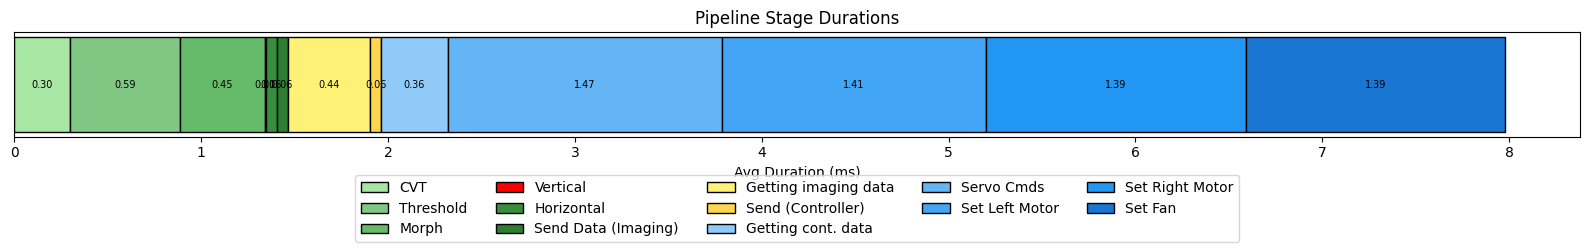

In [31]:
import matplotlib.pyplot as plt

# File paths
imaging_file = 'cpp-length/imaging.txt'
controller_file = 'cpp-length/controller.txt'
actuator_file = 'cpp-length/actuator.txt'

# Normalize keys function (imaging)
def normalize_key(k):
    k = k.lower().replace(' ', '').replace(':', '')
    corrections = {
        'recv': 'recvimg',
        'recvimg': 'recvimg',
        'horziontalslcing': 'horizontal',
        'horizontal': 'horizontal',
        'verticalslicing': 'vertical',
        'vertical': 'vertical',
        'threshold': 'thresh',
        'morphologyex': 'morph',
        'cvt': 'cvt',
        'send': 'send',
        'start': 'start',
        'end': 'end',
        'idts': 'idts',
        'idts': 'idts',
        'idts': 'idts',
        'endcontroller': 'end(controller)',
        'rcvdatats': 'rcvdatats',
        'servocmds': 'servocmds',
        'setleftmotor': 'setleft motor',
        'setrightmotor': 'set right motor',
        'setfan': 'set fan',
    }
    return corrections.get(k, k)


# Parse key/value lines into dict
def parse_line(line):
    data = {}
    parts = [p.strip().replace('"', '') for p in line.strip().split(",")]
    for part in parts:
        if ":" in part:
            k, v = part.split(":", 1)
            key = normalize_key(k.strip())
            try:
                data[key] = int(v.strip())
            except:
                pass
    return data


# Load only lines containing 'start'
def load_lines(filename):
    with open(filename, 'r') as f:
        return [l.strip() for l in f if 'start' in l.lower()]

imaging_lines = load_lines(imaging_file)
controller_lines = load_lines(controller_file)
actuator_lines = load_lines(actuator_file)

matched_durations = []

for img_line in imaging_lines:
    img_raw = parse_line(img_line)
    # Normalize imaging data
    img_data = {}
    for k, v in img_raw.items():
        nk = normalize_key(k)
        try:
            img_data[nk] = int(v)
        except:
            pass

    img_id = img_data.get('idts')
    if not img_id:
        continue

    ctrl_line = next(
        (l for l in controller_lines if str(img_id) in l),
        None
    )
    if not ctrl_line:
        continue
    ctrl_data = parse_line(ctrl_line)

    act_line = next(
        (l for l in actuator_lines if str(img_id) in l),
        None
    )
    if not act_line:
        continue
    act_data = parse_line(act_line)


    # Compute durations (ms)
    d = {
        # imaging
        "CVT": (img_data["cvt"] - img_data["recvimg"]) / 1000,
        "Threshold": (img_data["thresh"] - img_data["cvt"]) / 1000,
        "Morph": (img_data["morph"] - img_data["thresh"]) / 1000,
        "Vertical": (img_data["vertical"] - img_data["morph"]) / 1000,
        "Horizontal": (img_data["horizontal"] - img_data["vertical"]) / 1000,
        "Send Data (Imaging)": (img_data["end"] - img_data["horizontal"]) / 1000,
        # controller
        "Getting imaging data": (ctrl_data["send"] - img_data["horizontal"]) / 1000,
        "Send (Controller)": (ctrl_data.get("end(controller)", ctrl_data.get("end")) - ctrl_data["send"]) / 1000,
        # actuator
        "Getting cont. data": (act_data["rcvdatats"] - ctrl_data.get("end(controller)", ctrl_data.get("end"))) / 1000,
        "Servo Cmds": (act_data["servocmds"] - act_data["rcvdatats"]) / 1000,
        "Set Left Motor": (act_data["setleft motor"] - act_data["servocmds"]) / 1000,
        "Set Right Motor": (act_data["set right motor"] - act_data["setleft motor"]) / 1000,
        "Set Fan": (act_data["set fan"] - act_data["set right motor"]) / 1000,
    }
    matched_durations.append(d)

if not matched_durations:
    raise ValueError("No matching data found.")

# Average and plot
labels = list(matched_durations[0].keys())
avg = {k: 0 for k in labels}
n = len(matched_durations)

for frame in matched_durations:
    for k in labels:
        avg[k] += frame[k]

for k in avg:
    avg[k] /= n

imaging_colors = [
    '#A8E6A3',  # CVT
    '#81C784',  # Threshold
    '#66BB6A',  # Morph
    'red',  # Vertical
    '#388E3C',  # Horizontal
    '#2E7D32'   # Send Data (Imaging)
]
controller_colors = [
    '#FFF176',  # Getting imaging data
    '#FFD54F'   # Send (Controller)
]
actuator_colors = [
    '#90CAF9',  # Getting cont. data
    '#64B5F6',  # Servo Cmds
    '#42A5F5',  # Set Left Motor
    '#2196F3',  # Set Right Motor
    '#1976D2'   # Set Fan
]
colors = imaging_colors + controller_colors + actuator_colors



plt.figure(figsize=(16,3))
left = 0
for i, key in enumerate(labels):
    val = avg[key]
    plt.barh(0, val, left=left, color=colors[i], edgecolor='black', label=key)
    plt.text(left + val/2, 0, f"{val:.2f}", va='center', ha='center', fontsize=7)
    left += val

plt.yticks([])
plt.xlabel("Avg Duration (ms)")
plt.title("Pipeline Stage Durations")
plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.3), ncol=5)
plt.tight_layout()
plt.show()


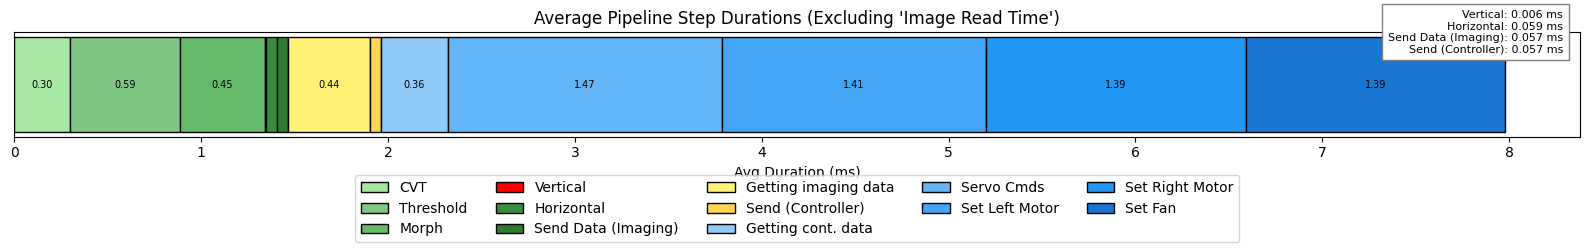

In [32]:
plt.figure(figsize=(16, 3))

left = 0
small_labels = []  # Store small durations here

for i, key in enumerate(labels):
    val = avg[key]
    plt.barh(0, val, left=left, color=colors[i], edgecolor='black', label=key)

    if val > 0.2:
        plt.text(left + val / 2, 0, f"{val:.2f}", va='center', ha='center', fontsize=7)
    else:
        small_labels.append(f"{key}: {val:.3f} ms")

    left += val

plt.yticks([])
plt.xlabel("Avg Duration (ms)")
plt.title("Average Pipeline Step Durations (Excluding 'Image Read Time')")

# Add small durations in the upper right corner
if small_labels:
    text = "\n".join(small_labels)
    plt.gcf().text(0.98, 0.95, text, ha='right', va='top', fontsize=8, bbox=dict(facecolor='white', edgecolor='gray'))

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=5)
plt.tight_layout()
plt.show()


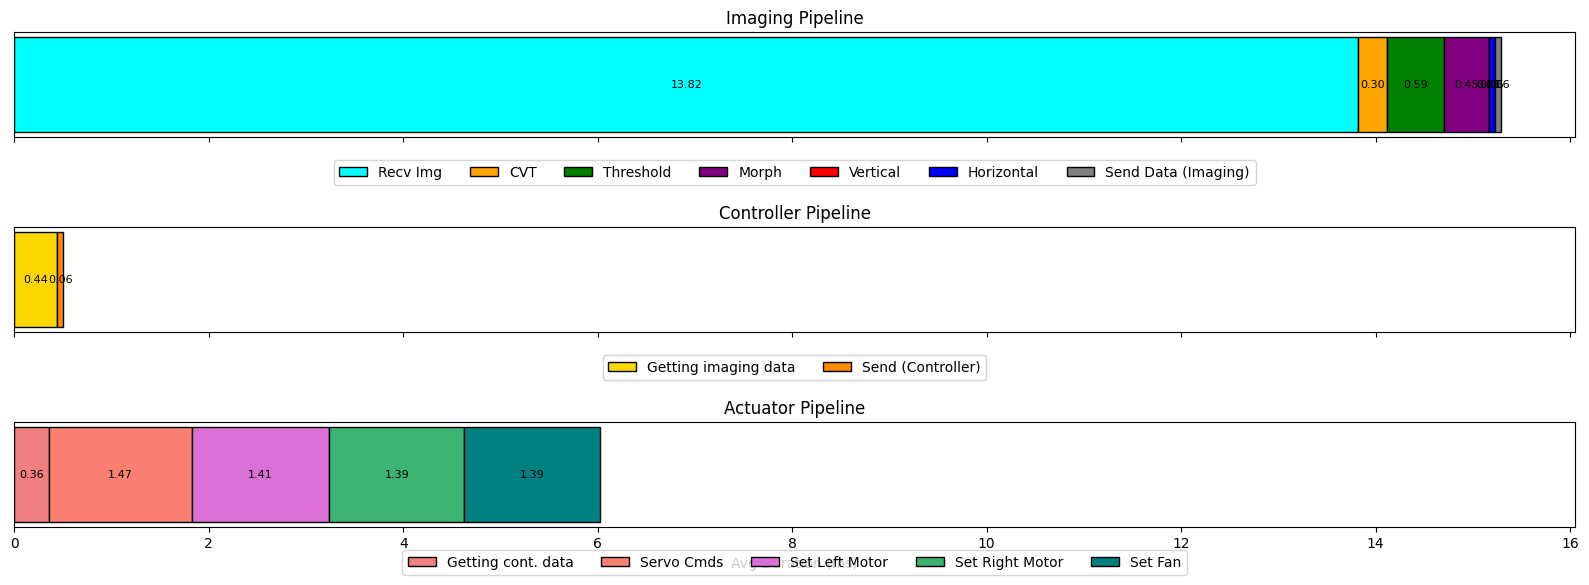

In [33]:
import matplotlib.pyplot as plt

# Add "Recv Img" stage to imaging labels and colors at the start
imaging_labels = ["Recv Img", "CVT", "Threshold", "Morph", "Vertical", "Horizontal", "Send Data (Imaging)"]
imaging_colors = ['cyan', 'orange', 'green', 'purple', 'red', 'blue', 'gray']  # added cyan for Recv Img

controller_labels = ["Getting imaging data", "Send (Controller)"]
controller_colors = ['gold', 'darkorange']

actuator_labels = ["Getting cont. data", "Servo Cmds", "Set Left Motor", "Set Right Motor", "Set Fan"]
actuator_colors = ['lightcoral', 'salmon', 'orchid', 'mediumseagreen', 'teal']

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 6), sharex=True)

# Calculate Recv Img duration as (recvImg - start)
recv_img_duration = (img_data["recvimg"] - img_data["start"]) / 1000  # ms

# Imaging durations with added Recv Img at front
imaging_durations = [recv_img_duration] + [avg[key] for key in imaging_labels[1:]]

# Plot Imaging row
left = 0
for i, key in enumerate(imaging_labels):
    val = imaging_durations[i]
    axes[0].barh(0, val, left=left, color=imaging_colors[i], edgecolor='black', label=key)
    axes[0].text(left + val / 2, 0, f"{val:.2f}", va='center', ha='center', fontsize=8)
    left += val
axes[0].set_yticks([])
axes[0].set_title("Imaging Pipeline")
axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(imaging_labels))

# Plot Controller row (unchanged)
left = 0
for i, key in enumerate(controller_labels):
    val = avg[key]
    axes[1].barh(0, val, left=left, color=controller_colors[i], edgecolor='black', label=key)
    axes[1].text(left + val / 2, 0, f"{val:.2f}", va='center', ha='center', fontsize=8)
    left += val
axes[1].set_yticks([])
axes[1].set_title("Controller Pipeline")
axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(controller_labels))

# Plot Actuator row (unchanged)
left = 0
for i, key in enumerate(actuator_labels):
    val = avg[key]
    axes[2].barh(0, val, left=left, color=actuator_colors[i], edgecolor='black', label=key)
    axes[2].text(left + val / 2, 0, f"{val:.2f}", va='center', ha='center', fontsize=8)
    left += val
axes[2].set_yticks([])
axes[2].set_title("Actuator Pipeline")
axes[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(actuator_labels))

# Common x label
axes[2].set_xlabel("Avg Duration (ms)")

plt.tight_layout()
plt.show()


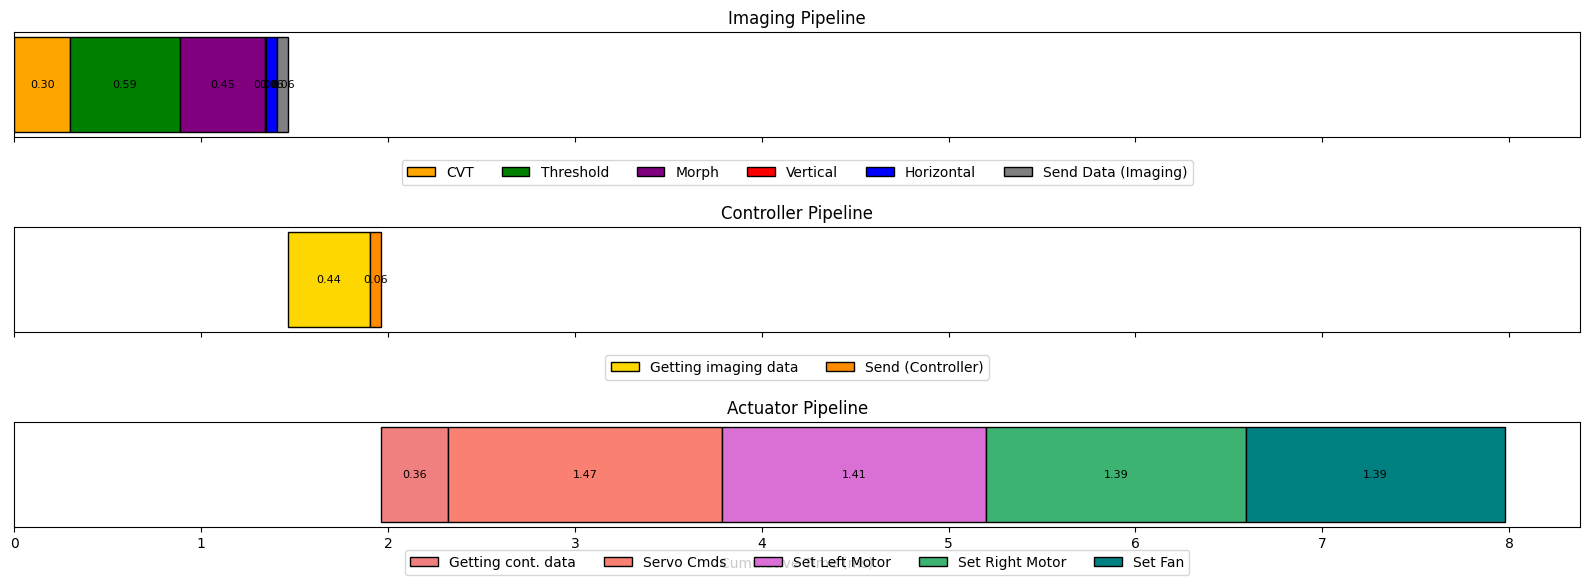


Average Duration by Pipeline Part:
  Imaging:    1.463 ms
  Controller: 0.500 ms
  Actuator:   6.018 ms
  Total:      7.980 ms


In [34]:
import matplotlib.pyplot as plt

# Stage labels and colors (without "Recv Img")
imaging_labels = ["CVT", "Threshold", "Morph", "Vertical", "Horizontal", "Send Data (Imaging)"]
imaging_colors = ['orange', 'green', 'purple', 'red', 'blue', 'gray']

controller_labels = ["Getting imaging data", "Send (Controller)"]
controller_colors = ['gold', 'darkorange']

actuator_labels = ["Getting cont. data", "Servo Cmds", "Set Left Motor", "Set Right Motor", "Set Fan"]
actuator_colors = ['lightcoral', 'salmon', 'orchid', 'mediumseagreen', 'teal']

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 6), sharex=True)

# Imaging durations (excluding Recv Img)
imaging_durations = [avg[key] for key in imaging_labels]

# === Imaging Pipeline ===
imaging_total = sum(imaging_durations)
left = 0
for i, key in enumerate(imaging_labels):
    val = imaging_durations[i]
    axes[0].barh(0, val, left=left, color=imaging_colors[i], edgecolor='black', label=key)
    axes[0].text(left + val / 2, 0, f"{val:.2f}", va='center', ha='center', fontsize=8)
    left += val
axes[0].set_yticks([])
axes[0].set_title("Imaging Pipeline")
axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(imaging_labels))

# === Controller Pipeline (starts after Imaging) ===
controller_durations = [avg[key] for key in controller_labels]
left = imaging_total
for i, key in enumerate(controller_labels):
    val = controller_durations[i]
    axes[1].barh(0, val, left=left, color=controller_colors[i], edgecolor='black', label=key)
    axes[1].text(left + val / 2, 0, f"{val:.2f}", va='center', ha='center', fontsize=8)
    left += val
controller_total = sum(controller_durations)
axes[1].set_yticks([])
axes[1].set_title("Controller Pipeline")
axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(controller_labels))

# === Actuator Pipeline (starts after Controller) ===
actuator_durations = [avg[key] for key in actuator_labels]
left = imaging_total + controller_total
for i, key in enumerate(actuator_labels):
    val = actuator_durations[i]
    axes[2].barh(0, val, left=left, color=actuator_colors[i], edgecolor='black', label=key)
    axes[2].text(left + val / 2, 0, f"{val:.2f}", va='center', ha='center', fontsize=8)
    left += val
axes[2].set_yticks([])
axes[2].set_title("Actuator Pipeline")
axes[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(actuator_labels))

# X-axis label
axes[2].set_xlabel("Cumulative Time (ms)")

plt.tight_layout()
plt.show()

# --- Compute average duration of each pipeline part ---
imaging_total = sum([avg[key] for key in imaging_labels])
controller_total = sum([avg[key] for key in controller_labels])
actuator_total = sum([avg[key] for key in actuator_labels])
overall_total = imaging_total + controller_total + actuator_total

# --- Print results ---
print("\nAverage Duration by Pipeline Part:")
print(f"  Imaging:    {imaging_total:.3f} ms")
print(f"  Controller: {controller_total:.3f} ms")
print(f"  Actuator:   {actuator_total:.3f} ms")
print(f"  Total:      {overall_total:.3f} ms")


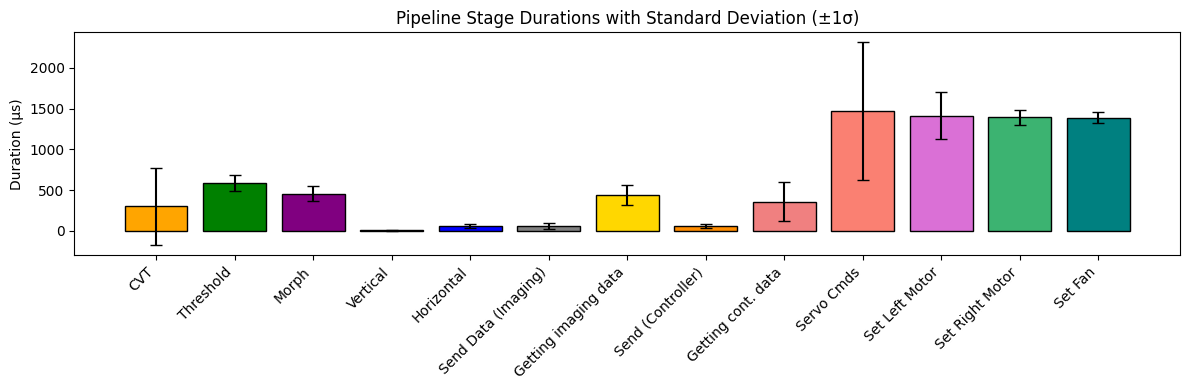


Pipeline Stage Average Durations ± Standard Deviations (in μs):
CVT                 : 299 ± 476 μs
Threshold           : 587 ± 104 μs
Morph               : 454 ± 93 μs
Vertical            : 6 ± 3 μs
Horizontal          : 59 ± 22 μs
Send Data (Imaging) : 57 ± 40 μs
Getting imaging data: 443 ± 121 μs
Send (Controller)   : 57 ± 22 μs
Getting cont. data  : 358 ± 239 μs
Servo Cmds          : 1465 ± 845 μs
Set Left Motor      : 1414 ± 291 μs
Set Right Motor     : 1392 ± 91 μs
Set Fan             : 1389 ± 68 μs

Average σ across all stages: 186 μs

Sum of average durations: 7980 μs

Sum of average durations (Imaging steps): 1463 μs


In [35]:
import numpy as np
import matplotlib.pyplot as plt

# --- Labels & colors for every step ---
all_labels = (
    ["CVT", "Threshold", "Morph", "Vertical", "Horizontal", "Send Data (Imaging)"] +
    ["Getting imaging data", "Send (Controller)"] +
    ["Getting cont. data", "Servo Cmds", "Set Left Motor", "Set Right Motor", "Set Fan"]
)
all_colors = (
    ['orange', 'green', 'purple', 'red', 'blue', 'gray'] +
    ['gold', 'darkorange'] +
    ['lightcoral', 'salmon', 'orchid', 'mediumseagreen', 'teal']
)

# Create a dict to hold all durations for each label (in μs)
all_durations_per_step = {label: [] for label in all_labels}

# Fill durations per step from all frames (convert from ms to μs)
for frame in matched_durations:
    for label in all_labels:
        # matched_durations values are currently in ms, convert to μs:
        all_durations_per_step[label].append(frame[label] * 1000)

# Compute average and stddev per step in μs
avg_us = {label: np.mean(all_durations_per_step[label]) for label in all_labels}
step_stddev_us = {label: float(np.std(all_durations_per_step[label], ddof=1)) for label in all_labels}

# Prepare data for plotting
means = [avg_us[l] for l in all_labels]
errs = [step_stddev_us[l] for l in all_labels]
x = np.arange(len(all_labels))

plt.figure(figsize=(12, 4))
plt.bar(x, means, yerr=errs, capsize=4, color=all_colors, edgecolor='black')
plt.xticks(x, all_labels, rotation=45, ha='right')
plt.ylabel("Duration (μs)")
plt.title("Pipeline Stage Durations with Standard Deviation (±1σ)")
plt.tight_layout()
plt.show()

# Print results in μs
print("\nPipeline Stage Average Durations ± Standard Deviations (in μs):")
for step in all_labels:
    print(f"{step:20s}: {avg_us[step]:.0f} ± {step_stddev_us[step]:.0f} μs")

avg_std_us = np.mean(list(step_stddev_us.values()))
print(f"\nAverage σ across all stages: {avg_std_us:.0f} μs")

# Compute sum of average durations (μs)
sum_avg_duration_us = sum(avg_us.values())

# Compute average of standard deviations (μs)
avg_stddev_us = np.mean(list(step_stddev_us.values()))

print(f"\nSum of average durations: {sum_avg_duration_us:.0f} μs")

# Imaging steps subset
imaging_steps = ["CVT", "Threshold", "Morph", "Vertical", "Horizontal", "Send Data (Imaging)"]

# Sum of average durations for imaging steps (μs)
sum_avg_imaging_us = sum(avg_us[step] for step in imaging_steps)

print(f"\nSum of average durations (Imaging steps): {sum_avg_imaging_us:.0f} μs")



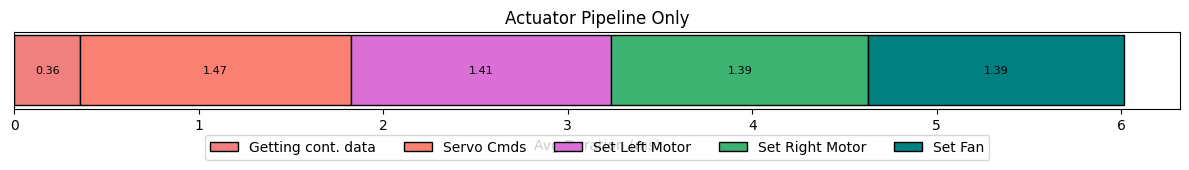

Servo Cmds: 1.47 ms
Set Left Motor: 1.41 ms
Set Right Motor: 1.39 ms
Set Fan: 1.39 ms


In [36]:
import matplotlib.pyplot as plt

# Only actuator labels and corresponding colors
actuator_labels = ["Getting cont. data", "Servo Cmds", "Set Left Motor", "Set Right Motor", "Set Fan"]
actuator_colors = ['lightcoral', 'salmon', 'orchid', 'mediumseagreen', 'teal']

# Extract only actuator durations from the avg dictionary
actuator_durations = [avg[label] for label in actuator_labels]

# Plot actuator stages
plt.figure(figsize=(12, 2))
left = 0
for i, (label, color) in enumerate(zip(actuator_labels, actuator_colors)):
    val = actuator_durations[i]
    plt.barh(0, val, left=left, color=color, edgecolor='black', label=label)
    plt.text(left + val / 2, 0, f"{val:.2f}", va='center', ha='center', fontsize=8)
    left += val

plt.yticks([])
plt.xlabel("Avg Duration (ms)")
plt.title("Actuator Pipeline Only")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=5)
plt.tight_layout()
plt.show()


command_labels = ["Servo Cmds", "Set Left Motor", "Set Right Motor", "Set Fan"]

for label in command_labels:
    print(f"{label}: {avg[label]:.2f} ms")

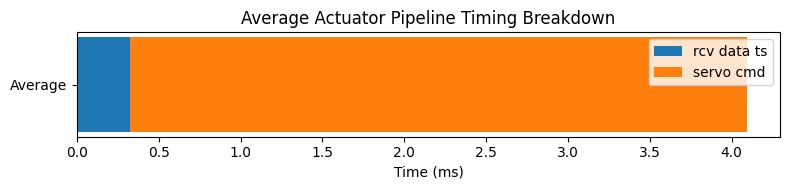

Average servo cmd duration: 3.766 ms


In [37]:
import matplotlib.pyplot as plt

ACTUATOR_FILE = "cpp-act-len/attempt1.txt"
CONTROLLER_FILE = "cpp-act-len/controller.txt"

def parse_line(line):
    d = {}
    parts = line.strip().split(",")
    for part in parts:
        part = part.strip().replace('"', '')
        if ":" not in part:
            continue
        key, val = part.split(":", 1)
        key = key.lower().replace(" ", "")
        try:
            val = int(val.strip())
        except ValueError:
            continue
        d[key] = val
    return d

def load_data(filename):
    with open(filename, 'r') as f:
        return [parse_line(line) for line in f if line.strip()]

# Load data
actuator_lines = load_data(ACTUATOR_FILE)
controller_lines = load_data(CONTROLLER_FILE)

# Build dict from controller by id ts for quick lookup
controller_by_id = {entry['idts']: entry for entry in controller_lines if 'idts' in entry and 'end(controller)' in entry}

durations = []

for act in actuator_lines:
    id_ts = act.get('idts')
    if id_ts is None or id_ts not in controller_by_id:
        continue
    ctrl = controller_by_id[id_ts]
    end_ctrl = ctrl['end(controller)']

    rcv_data_ts = act.get('rcvdatats')
    servo_cmds = act.get('servocmds')
    set_left = act.get('setleftmotor')
    set_right = act.get('setrightmotor')
    set_fan = act.get('setfan')

    # Make sure all needed keys exist
    if None in (rcv_data_ts, servo_cmds, set_left, set_right, set_fan):
        continue

    # Calculate durations in microseconds
    d_rcv_data_ts = rcv_data_ts - end_ctrl
    d_servo_cmds = servo_cmds - rcv_data_ts
    d_set_left = set_left - servo_cmds
    d_set_right = set_right - set_left
    d_set_fan = set_fan - set_right

    durations.append([d_rcv_data_ts, d_servo_cmds, d_set_left, d_set_right, d_set_fan])

if not durations:
    raise RuntimeError("No matching data found between actuator and controller.")

# Average durations in milliseconds
avg_durations = [sum(stage) / len(stage) / 1000 for stage in zip(*durations)]

labels = ["rcv data ts", "servo cmd"]

# Plot
fig, ax = plt.subplots(figsize=(8, 2))
bottom = 0
for dur, label in zip(avg_durations, labels):
    ax.barh(0, dur, left=bottom, height=0.5, label=label)
    bottom += dur

ax.set_yticks([0])
ax.set_yticklabels(["Average"])
ax.set_xlabel("Time (ms)")
ax.set_title("Average Actuator Pipeline Timing Breakdown")
ax.legend()
plt.tight_layout()
plt.show()

# Average durations already computed as avg_durations
# servo cmd is the second element (index 1)
avg_servo_cmd = avg_durations[1]

print(f"Average servo cmd duration: {avg_servo_cmd:.3f} ms")




In [38]:
import re
import statistics

# File path
FILENAME = "pixel-access-base.txt"  # Change this to your actual filename

# Lists to hold timings
getvec_times = []
flatptr_times = []

# Regular expression to extract timings
pattern = re.compile(r"GetVecAt:\s*(\d+)\s*µs.*FlatPtr:\s*(\d+)\s*µs")

# Read file and parse lines
with open(FILENAME, 'r') as f:
    for line in f:
        match = pattern.search(line)
        if match:
            getvec = int(match.group(1))
            flatptr = int(match.group(2))
            getvec_times.append(getvec)
            flatptr_times.append(flatptr)



# Compute stats
if getvec_times and flatptr_times:
    print(f"GetVecAt - Avg: {statistics.mean(getvec_times):.2f} µs, Std Dev: {statistics.stdev(getvec_times):.2f} µs")
    print(f"FlatPtr  - Avg: {statistics.mean(flatptr_times):.2f} µs, Std Dev: {statistics.stdev(flatptr_times):.2f} µs")
else:
    print("No valid data found.")


GetVecAt - Avg: 1589.94 µs, Std Dev: 208.57 µs
FlatPtr  - Avg: 25.81 µs, Std Dev: 8.66 µs


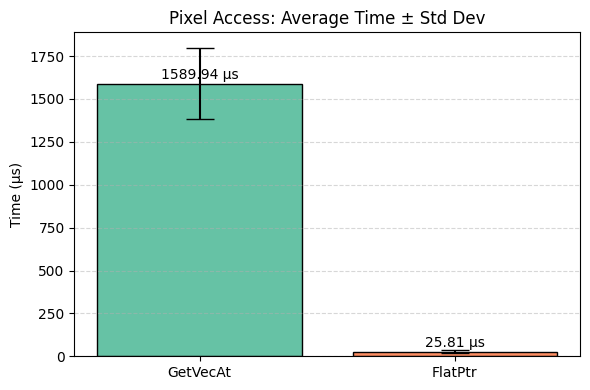

In [39]:
import matplotlib.pyplot as plt

# Compute averages and standard deviations
getvec_avg = statistics.mean(getvec_times)
getvec_std = statistics.stdev(getvec_times)
flatptr_avg = statistics.mean(flatptr_times)
flatptr_std = statistics.stdev(flatptr_times)

# Bar chart with error bars
labels = ['GetVecAt', 'FlatPtr']
averages = [getvec_avg, flatptr_avg]
std_devs = [getvec_std, flatptr_std]

colors = ['#66c2a5', '#fc8d62']

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, averages, yerr=std_devs, capsize=10, color=colors, edgecolor='black')

# Annotate each bar with the average time
for bar, avg in zip(bars, averages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + max(std_devs)*0.05,
             f'{avg:.2f} µs', ha='center', va='bottom', fontsize=10)

plt.ylabel("Time (µs)")
plt.title("Pixel Access: Average Time ± Std Dev")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
